# Image Classification

#### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.keras
from glob import glob
import cv2
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import shutil

#### Loading Images and Labels

In [3]:
# os.chdir('C:/Users/Vedant/Downloads/')
labels_location_list = glob('visiolab-food-detection/train/labels/*.txt')

labels = []
for file in range(len(labels_location_list)):
    with open(labels_location_list[file], 'r') as f:
        textData = f.readline()
        labels.append(textData[0])
        
images_location_list = glob('visiolab-food-detection/train/images/*.jpg')
data = []
for f1 in range(len(images_location_list)):
    img = cv2.imread(images_location_list[f1])[:,:,::-1]
    data.append(img)
    
len(labels), len(data), len(labels_location_list)

(233, 233, 233)

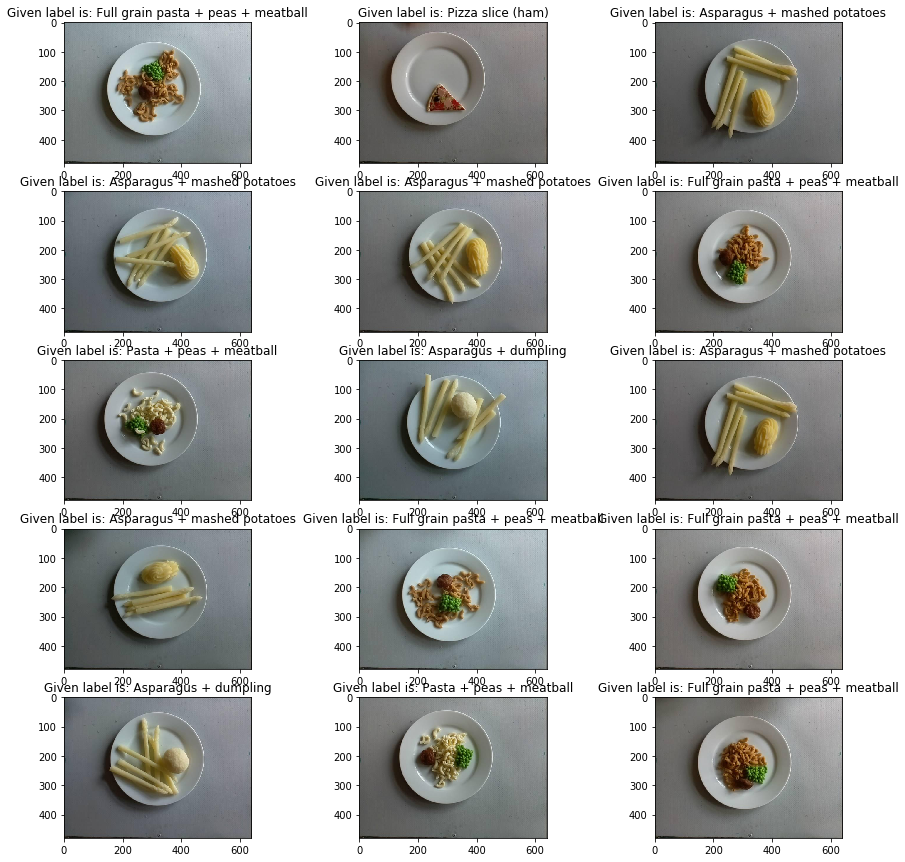

In [4]:
labelNames = {'0': 'Asparagus + mashed potatoes', '1': 'Asparagus + dumpling', '2': 'Pasta + peas + meatball','3' :'Full grain pasta + peas + meatball', '4': 'Tortellini + meat', '5': 'Pizza slice (ham)', '6': 'Pizza slice (mushroom)'} 
input_label_names = [labelNames[item] for item in labels]

fig=plt.figure(figsize=(15, 15))
columns = 3
rows = 5
for i in range(1, columns*rows +1):
    import matplotlib.image as mpimg
    x = np.random.randint(0,200)
    img=mpimg.imread(images_location_list[x])
    img=data[x]
    fig.add_subplot(rows, columns, i)
    plt.title('Given label is: {}'.format(input_label_names[x]))
    plt.imshow(img)
plt.show()

In [5]:
class create_data_model:
    
    def __init__(self, split_size, SOURCE_DIR):
        self.split_size = split_size
        self.SOURCE_DIR = SOURCE_DIR
        
    def _split_save_data (self):
        SOURCE_DIR = self.SOURCE_DIR
        split_size = self.split_size

        images_location_list =  glob(SOURCE_DIR + '/images/*.jpg')
        labels_location_list = glob(SOURCE_DIR + '/labels/*.txt')
        tr = 'training/'
        te = 'testing/'

        TRAINING_DIR = SOURCE_DIR + '/images/' + tr
        TESTING_DIR = SOURCE_DIR + '/images/' + te
        os.mkdir(TRAINING_DIR)
        os.mkdir(TESTING_DIR)
        training_length = int(len(images_location_list) * split_size)
        testing_length = int(len(images_location_list) - training_length)
        shuffled_images_set, shuffled_labels_set = zip(*random.sample(list(zip(images_location_list, labels_location_list)), len(labels_location_list)))
    #     shuffled_images_set = random.sample(images_location_list, len(images_location_list))
        training_images_set = shuffled_images_set[0:training_length]
        training_labels_set = shuffled_labels_set[0:training_length]
        testing_images_set = shuffled_images_set[:testing_length]
        testing_labels_set = shuffled_labels_set[:testing_length]


        for fileName in range(len(training_images_set)):
            shutil.copy( training_images_set[fileName], TRAINING_DIR)
        for fileName in range(len(training_labels_set)):
            shutil.copy( training_labels_set[fileName], TRAINING_DIR)
        for fileName in range(len(testing_images_set)):
            shutil.copy( testing_images_set[fileName], TESTING_DIR)
        for fileName in range(len(testing_labels_set)):
            shutil.copy( testing_labels_set[fileName], TESTING_DIR)


        training_labels_location_list = glob(TRAINING_DIR + '/*.txt')
        testing_labels_location_list = glob(TESTING_DIR + '/*.txt')
        training_images_location_list = glob(TRAINING_DIR + '/*.jpg')
        testing_images_location_list = glob(TESTING_DIR + '/*.jpg')

        train_labels = []
        test_labels = []
        for file in range(len(training_labels_location_list)):
            with open(training_labels_location_list[file], 'r') as f:
                textData = f.readline()
                train_labels.append(textData[0])

        for file in range(len(testing_labels_location_list)):
            with open(testing_labels_location_list[file], 'r') as f:
                textData = f.readline()
                test_labels.append(textData[0])

        trainDf = pd.DataFrame()
        trainDf['imageLocation'] = training_images_location_list
        trainDf['labels'] = train_labels
        testDf = pd.DataFrame()
        testDf['imageLocation'] = testing_images_location_list
        testDf['labels'] = test_labels

        train_ul = list(trainDf.labels.unique())
        test_ul = list(testDf.labels.unique())


        Names = {'0': 'Asparagus + mashed potatoes', '1': 'Asparagus + dumpling', '2': 'Pasta + peas + meatball','3' :'Full grain pasta + peas + meatball', '4': 'Tortellini + meat', '5': 'Pizza slice (ham)', '6': 'Pizza slice (mushroom)'} 
        telt = testDf.labels.tolist()
        trlt = trainDf.labels.tolist()
        test_labels_names = [Names[item] for item in telt]
        train_labels_names = [Names[item] for item in trlt]

        trainDf['labelsName'] = train_labels_names
        testDf['labelsName'] = test_labels_names

        for ele in trainDf.labelsName.unique().tolist():
            tmp = trainDf.imageLocation[trainDf.labelsName == ele].tolist()
            os.mkdir(TRAINING_DIR+ele)
            for fileName in range(len(tmp)):
                shutil.move( tmp[fileName], TRAINING_DIR+ele)

        for ele in testDf.labelsName.unique().tolist():
            tmp = testDf.imageLocation[testDf.labelsName == ele].tolist()
            os.mkdir(TESTING_DIR+ele)
            for fileName in range(len(tmp)):
                shutil.move( tmp[fileName], TESTING_DIR+ele)

        print('\n Training Direcotry is: {}'.format(TRAINING_DIR))
        print('\n Testing Direcotry is: {}'.format(TESTING_DIR))
        print('\n Data is dristributed in Train and Test also subcategorized as per classes.')
        
        
    def _augmenting_images(self,TRAINING_DIR, TESTING_DIR):
        self.TRAINING_DIR = TRAINING_DIR
        self.TESTING_DIR = TESTING_DIR
        VALIDATION_DIR = self.TESTING_DIR
 
        # Add our data-augmentation parameters to ImageDataGenerator
        train_datagen = ImageDataGenerator(rescale = 1./255.,
                                           rotation_range = 40,
                                           width_shift_range = 0.2,
                                           height_shift_range = 0.2,
                                           shear_range = 0.2,
                                           zoom_range = 0.2,
                                           horizontal_flip = True)

        # Note that the validation data should not be augmented!
        test_datagen = ImageDataGenerator( rescale = 1.0/255. )

        # Flow training images in batches of 20 using train_datagen generator

        train_datagen = ImageDataGenerator(rescale=1.0/255.)
        train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                            batch_size=32,
                                                            class_mode='categorical',
                                                            target_size=(480, 640))

        # Flow validation images in batches of 20 using test_datagen generator
        validation_datagen = ImageDataGenerator(rescale=1.0/255.)
        validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                      batch_size=32,
                                                                      class_mode='categorical',
                                                                      target_size=(480, 640))


        return train_generator, validation_generator
    
    def _model(self, num_classes=7, learning_rate=0.001, ):
        self.num_classes = num_classes
        self.learning_rate = learning_rate

        tf.keras.backend.clear_session()
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (2,2), padding='same', input_shape=(480,640,3), activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=(2,2)),
            tf.keras.layers.Conv2D(64, (2,2), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=(2,2)),
            tf.keras.layers.Conv2D(128, (2,2), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=(2,2)),
            tf.keras.layers.Conv2D(256, (2,2), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=(2,2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation=tf.nn.relu),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation=tf.nn.relu),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(16, activation=tf.nn.relu),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(self.num_classes, activation='softmax')

        ])

        Adam = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(loss='categorical_crossentropy', optimizer=Adam, metrics=['acc'])
        model.summary()
        return model


In [6]:
data_model = create_data_model(0.9, 'visiolab-food-detection1/train/')

In [7]:
data_model._split_save_data()


 Training Direcotry is: C:/Users/Vedant/Downloads/visiolab-food-detection1/train//images/training/

 Testing Direcotry is: C:/Users/Vedant/Downloads/visiolab-food-detection1/train//images/testing/

 Data is dristributed in Train and Test also subcategorized as per classes.


In [9]:
train_generator , validation_generator = data_model._augmenting_images('visiolab-food-detection1/train//images/training/', 'C:/Users/Vedant/Downloads/visiolab-food-detection1/train//images/testing/')

Found 209 images belonging to 7 classes.
Found 24 images belonging to 7 classes.


In [11]:
model  = data_model._model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 480, 640, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 240, 320, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 240, 320, 64)      8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 160, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 160, 128)     32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 80, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 80, 256)       1

In [18]:
tensorboard = TensorBoard(
  log_dir = 'c:/logs/',
#   histogram_freq=1,
  write_images=True
)
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=1)

epochs = 21

history = model.fit_generator(train_generator, epochs=epochs, verbose=1, validation_data= validation_generator,callbacks = [tensorboard])

Epoch 1/21
7/7 [==============================] - 49s 7s/step - loss: 0.5389 - acc: 0.7895 - val_loss: 0.2084 - val_acc: 0.8750
Epoch 2/21
7/7 [==============================] - 48s 7s/step - loss: 0.4284 - acc: 0.8230 - val_loss: 0.1269 - val_acc: 0.9583
Epoch 3/21
7/7 [==============================] - 48s 7s/step - loss: 0.5041 - acc: 0.7703 - val_loss: 0.1226 - val_acc: 0.9583
Epoch 4/21
7/7 [==============================] - 48s 7s/step - loss: 0.4918 - acc: 0.8325 - val_loss: 0.1372 - val_acc: 0.9583
Epoch 5/21
7/7 [==============================] - 48s 7s/step - loss: 0.4581 - acc: 0.8086 - val_loss: 0.1417 - val_acc: 0.9583
Epoch 6/21
7/7 [==============================] - 49s 7s/step - loss: 0.4161 - acc: 0.8182 - val_loss: 0.0996 - val_acc: 1.0000
Epoch 7/21
7/7 [==============================] - 48s 7s/step - loss: 0.3229 - acc: 0.8708 - val_loss: 0.0872 - val_acc: 1.0000
Epoch 8/21
7/7 [==============================] - 48s 7s/step - loss: 0.3533 - acc: 0.8517 - val_loss: 0

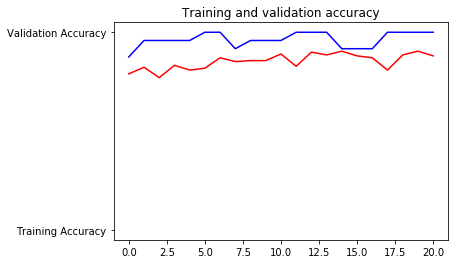

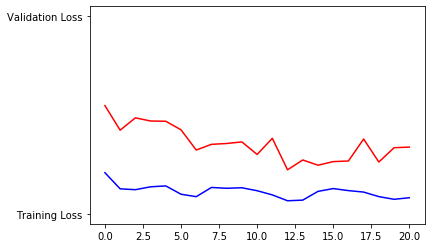

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.image  as mpimg

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()
plt.show()


In [20]:
from keras.preprocessing import image

test_images = glob('./visiolab-food-detection/test/images/*.jpg')
test_data = []
for f1 in range(len(test_images)):
    img = cv2.imread(test_images[f1])[:,:,::-1]
    test_data.append(img)
    
input_test_data = np.array(test_data)
input_test_data = input_test_data / 255
input_test_data.shape

classes = model.predict(input_test_data, batch_size=10)


[2.3385028e-05 4.7329492e-03 1.4969585e-05 1.4545589e-03 6.9676322e-01
 2.9697633e-01 3.4515146e-05]


In [21]:
predicted_test_labels = np.argmax(classes, axis=1)

In [22]:
predicted_test_labels

array([4, 0, 6, 6, 3, 6, 2, 2, 4, 2, 6, 1, 1, 0, 3, 6, 2, 3, 2, 4, 0, 4,
       3, 1, 0, 2, 0, 3, 0, 6, 1, 0, 3, 0, 6, 3, 4, 1, 4, 3, 0, 3, 1, 6,
       3, 1, 0, 3, 1, 3], dtype=int64)

In [23]:
labelNames = {0: 'Asparagus + mashed potatoes', 1: 'Asparagus + dumpling', 2: 'Pasta + peas + meatball',3 :'Full grain pasta + peas + meatball', 4: 'Tortellini + meat', 5: 'Pizza slice (ham)', 6: 'Pizza slice (mushroom)'} 
predicted_test_labels = [labelNames[item] for item in predicted_test_labels]


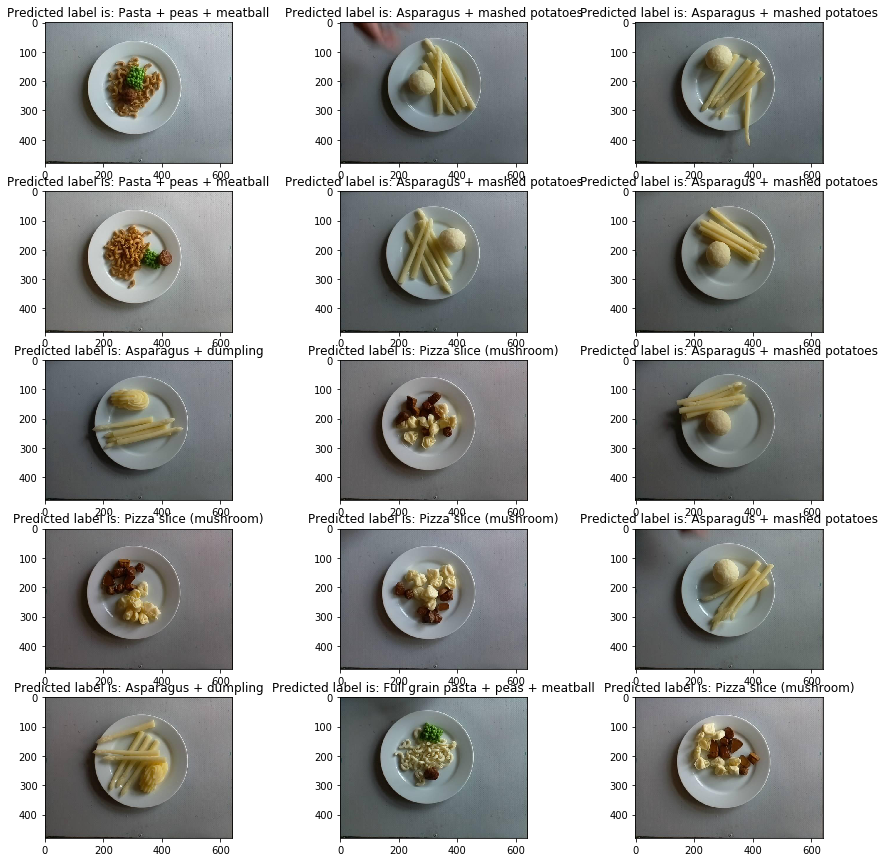

In [24]:

fig=plt.figure(figsize=(15, 15))
columns = 3
rows = 5
for i in range(1, columns*rows +1):
    import matplotlib.image as mpimg
    x = np.random.randint(0,50)
    img=mpimg.imread(test_images[x])
    fig.add_subplot(rows, columns, i)
    plt.title('Predicted label is: {}'.format(predicted_test_labels[x]))
    plt.imshow(img)
plt.show()